In [1]:
import geopandas as gpd
import rasterio
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from shapely.geometry import box
from rasterio.transform import xy
import pandas as pd
from tqdm import tqdm
from rasterio.windows import Window
import concurrent.futures
from dem_stitcher.geojson_io import to_geojson_gzip, read_geojson_gzip
from skimage.restoration import denoise_tv_bregman
from rasterio.profiles import DefaultGTiffProfile
import torch
from torch.utils.data import Dataset, DataLoader
import bisect

# Custom Dataset

In [2]:
from functools import lru_cache

@lru_cache
def open_rtc_table() -> pd.DataFrame:
    return pd.read_json('../4_rtc_organization/rtc_s1_table.json.zip')

@lru_cache
def open_patch_table() -> pd.DataFrame:
    return pd.read_json('dist_s1_patch_lut.json.zip')

In [3]:
def despeckle_one(X: np.ndarray, reg_param=2, noise_floor_db = -22) -> np.ndarray:
    X_c = np.clip(X, 1e-7, 1)
    X_db = 10 * np.log10(X_c, out=np.full(X_c.shape, np.nan), where=(~np.isnan(X_c)))
    X_db[np.isnan(X_c)] = noise_floor_db
    X_db_dspkl = denoise_tv_bregman(X_db, weight=1/2., isotropic=True, eps=1e-3)
    X_dspkl = np.power(10, X_db_dspkl / 10.)
    X_dspkl[np.isnan(X)] = np.nan
    X_dspkl = np.clip(X_dspkl, 0, 1)
    return X_dspkl

In [4]:
def read_window(url: str,
                x_start,
                y_start,
                x_stop,
                y_stop) -> np.ndarray:
    rows = (y_start, y_stop)
    cols = (x_start, x_stop)
    window = Window.from_slices(rows=rows, cols=cols)

    with rasterio.open(url) as ds:
        X = ds.read(1, window=window)
        t_window = ds.window_transform(window)
        crs = ds.crs
        
    p = DefaultGTiffProfile()
    p['dtype'] = 'float32'
    p['transform'] = t_window
    p['crs'] = crs
    p['nodata'] = np.nan
    p['count'] = 1
    p['height'], p['width'] = X.shape
    
    return X, p


class SeqDistDataset(Dataset):
    def __init__(self, 
                 rtc_table: str  = None, 
                 patch_table: str = None,
                 n_pre_imgs = 4,
                 transform=None):

        self.rtc_table = rtc_table or open_rtc_table()
        self.patch_table = patch_table or open_patch_table()
        self.n_pre_imgs = n_pre_imgs
        
        self.burst_ids = list(self.rtc_table.jpl_burst_id.unique())
        self._total_samples = None
        self._df_count = None
        
    @property
    def df_count(self):
        if self._df_count is None:
            df_acq_per_burst = self.rtc_table.groupby('jpl_burst_id').size().reset_index(name='acq_per_burst')
            df_patch_per_burst = self.patch_table.groupby('jpl_burst_id').size().reset_index(name='patch_per_burst')

            df_count = pd.merge(df_acq_per_burst, df_patch_per_burst, on='jpl_burst_id').reset_index(drop=True)
            df_count['total_samples_per_burst'] = np.maximum(df_count['acq_per_burst'] - self.n_pre_imgs - 1, 0) * df_count['patch_per_burst']
            df_count = df_count[df_count['total_samples_per_burst'] > 0].reset_index(drop=True)
            df_count['cum_samples'] = df_count['total_samples_per_burst'].cumsum()
            self._df_count = df_count
            return self._df_count
        else:
            return self._df_count
            
    @property
    def total_samples(self):
        if self._total_samples is None:
            df_count = self.df_count
            self._total_samples = df_count['total_samples_per_burst'].sum()
            return self._total_samples
        else:
            return self._total_samples

    def acqs_per_burst(self, burst_id: str):
        df_burst_count = self.df_count[self.df_count.jpl_burst_id == burst_id].reset_index(drop=True)
        n = df_burst_count.iloc[0].acq_per_burst
        return n - self.n_pre_imgs

    def __len__(self):
        return self.total_samples
        
    def __getitem__(self, idx):
        
        # Always gets the index >= index
        burst_idx = bisect.bisect_left(self.df_count.cum_samples.tolist(), idx)
        
        burst_id = self.df_count.iloc[burst_idx].jpl_burst_id
        acq_for_burst = self.df_count.iloc[burst_idx].acq_per_burst
        patches_for_burst = self.df_count.iloc[burst_idx].patch_per_burst
        
        total_samples_cum = self.df_count.iloc[burst_idx].cum_samples if burst_idx > 0 else 0
        
        acq_idx = (idx - total_samples_cum) % acq_for_burst 
        df_ts_t = self.rtc_table[self.rtc_table.jpl_burst_id == burst_id].reset_index(drop=True)
        # Add 1 for post image
        df_ts = df_ts_t.iloc[acq_idx: acq_idx + self.n_pre_imgs + 1].reset_index(drop=True)

        patch_idx = (idx - total_samples_cum) % patches_for_burst
        patch_burst = self.patch_table[self.patch_table.jpl_burst_id == burst_id].reset_index(drop=True)
        patch_data = patch_burst.iloc[patch_idx].to_dict()
        def read_window_p(url: str):
            return read_window(url, 
                               patch_data['x_start'], patch_data['y_start'],
                               patch_data['x_stop'], patch_data['y_stop'])
        
        vv_data, ps = zip(*[read_window_p(url) for url in tqdm(df_ts.rtc_s1_vv_url, desc='loading vv')])
        vh_data, _  = zip(*[read_window_p(url) for url in tqdm(df_ts.rtc_s1_vh_url, desc='loading vh')])

        vv_data = [despeckle_one(vv) for vv in tqdm(vv_data, desc='tv for vv')]
        vh_data = [despeckle_one(vh) for vh in tqdm(vh_data, desc='tv for vh')]

        # A list of 2 x H X W imagery
        acq_data = [np.stack([vv, vh], axis=0) for (vv, vh) in zip(vv_data, vh_data)]

        # Input for modeling
        # pre img is n_pre_imgs X 2 X H X W
        pre_imgs = np.stack(acq_data[:self.n_pre_imgs], axis=0)
        # post img is 2 X H X W
        post_img = acq_data[-1]

        # additional metadata
        pre_dts = df_ts.iloc[acq_idx: acq_idx + self.n_pre_imgs].acq_datetime.tolist()
        post_dt = df_ts.loc[self.n_pre_imgs, 'acq_datetime']
        
 
        return {'pre_imgs': pre_imgs, 
                'post_img': post_img,
                #'pre_dts': pre_dts,
                #'post_dt': post_dt,
                #'profile': ps[0]
               }

In [5]:
dataset = SeqDistDataset()
for i, data in enumerate(dataset):
    break
data  

tv for vh: 100%|██████| 5/5 [00:00<00:00, 34.99it/s]


{'pre_imgs': array([[[[       nan,        nan,        nan, ..., 0.15647046,
           0.15467185, 0.15690249],
          [       nan,        nan,        nan, ..., 0.15385184,
           0.15120003, 0.14844516],
          [       nan,        nan,        nan, ..., 0.14145274,
           0.15255453, 0.15642293],
          ...,
          [0.12343763, 0.12268527, 0.11008325, ..., 0.12574006,
           0.12359062, 0.11736929],
          [0.11926358, 0.11836348, 0.11785081, ..., 0.12555777,
           0.12131651, 0.11955597],
          [0.11095869, 0.11684906, 0.11501189, ..., 0.12705104,
           0.12467641, 0.18340036]],
 
         [[       nan,        nan,        nan, ..., 0.03021033,
           0.02634145, 0.02366763],
          [       nan,        nan,        nan, ..., 0.02649936,
           0.02508834, 0.02094703],
          [       nan,        nan,        nan, ..., 0.02265941,
           0.02773797, 0.03001064],
          ...,
          [0.01903251, 0.0211992 , 0.02662393, ..., 0.0

In [6]:
data['pre_imgs'].shape

(4, 2, 224, 224)

In [7]:
data['post_img'].shape

(2, 224, 224)

In [8]:
(data['post_img'] == data['pre_imgs'][-1, ...]).sum()

0

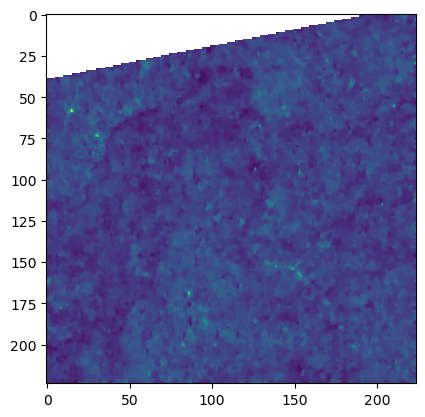

In [9]:
plt.imshow(data['post_img'][0])

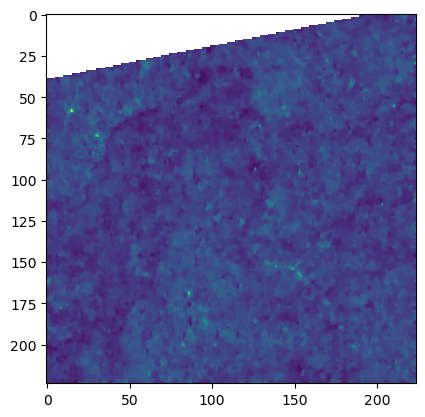

In [10]:
plt.imshow(data['post_img'][0])

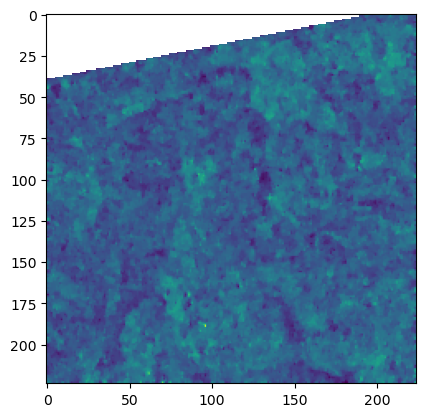

In [11]:
plt.imshow(data['post_img'][1])

In [12]:
# Dataloader

In [13]:
dataloader = DataLoader(dataset, 
                        batch_size=4,
                        shuffle=True)

In [16]:
for k, batch in enumerate(dataloader):
    break

tv for vh: 100%|██████| 5/5 [00:00<00:00, 34.63it/s]


In [17]:
batch['pre_imgs'].shape

torch.Size([4, 4, 2, 224, 224])